In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.io.shapereader as sr
from cartopy.feature import ShapelyFeature
import random
import geopandas as gpd
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import time

path = r'D:\Work\江西合作团队\PKU_CH4.xlsx'

df = pd.DataFrame()
fdir = pd.read_excel(path, sheet_name=None)
fdir1 = pd.read_excel(path, sheet_name=1)

df_sum = fdir['Other'].iloc[:, 2:] + fdir['Other1'].iloc[:, 2:] + fdir['Other2'].iloc[:, 2:]
df1 = pd.concat([fdir['Other'].iloc[:, :2], df_sum], axis=1)
vrs = ['Other', 'Other1', 'Other2']
for vr in vrs:
    del fdir[vr]
fdir['other'] = df1
keys = list(fdir.keys())

df0 = fdir1.iloc[:, [1]]  # 市名
key0 = list(fdir.keys())

lst = []
names = []
for name in df0['NAME']:
    locals()[f'df_{name}'] = pd.DataFrame()
    for value in fdir.values():
        dfn = value[value['NAME'] == name].loc[:, 2000:2019]
        dfn = dfn / (1000000000000000)
        locals()[f'df_{name}'] = pd.concat([locals()[f'df_{name}'], dfn], axis=0)
    locals()[f'df_{name}'].index = key0
    lst.append(locals()[f'df_{name}'])
    names.append(name)


In [2]:
def get_colors(n):
    colors = []
    for i in range(n):
        color = ''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        colors.append('#' + color)
    return colors


#-----------函数：添加比例尺--------------
def add_scalebar(ax,lon_x,lon_y,length,size=5):
    '''
    ax: 坐标轴
    lon0: 经度
    lat0: 纬度
    length: 长度
    size: 控制粗细和距离的
    '''
    # style 3
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    
    
    
    
    lon0 = lon_x*(xlen)+minx
    lat0 = lon_y*(ylen)+miny
    
    
    ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=1, label='%d km' % (length))
    ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.vlines(x = lon0+length/2/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    ax.text(lon0+length/111,lat0+size+0.05,'%d' % (length),horizontalalignment = 'center')
    ax.text(lon0+length/2/111,lat0+size+0.05,'%d' % (length/2),horizontalalignment = 'center')
    ax.text(lon0,lat0+size+0.05,'0',horizontalalignment = 'center')
    ax.text(lon0+length/111/2*3,lat0+size+0.05,'km',horizontalalignment = 'center')
    
    # style 1
    # print(help(ax.vlines))
    # ax.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=2, label='%d km' % (length))
    # ax.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=2)
    # ax.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=2)
    # # ax.text(lon0+length/2/111,lat0+size,'500 km',horizontalalignment = 'center')
    # ax.text(lon0+length/2/111,lat0+size,'%d' % (length/2),horizontalalignment = 'center')
    # ax.text(lon0,lat0+size,'0',horizontalalignment = 'center')
    # ax.text(lon0+length/111/2*3,lat0+size,'km',horizontalalignment = 'center')

    # style 2
    # plt.hlines(y=lat0,  xmin = lon0, xmax = lon0+length/111, colors="black", ls="-", lw=1, label='%d km' % (length))
    # plt.vlines(x = lon0, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    # plt.vlines(x = lon0+length/111, ymin = lat0-size, ymax = lat0+size, colors="black", ls="-", lw=1)
    # plt.text(lon0+length/111,lat0+size,'%d km' % (length),horizontalalignment = 'center')
    # plt.text(lon0,lat0+size,'0',horizontalalignment = 'center')

def add_north(ax, labelsize=18, loc_x=0.93, loc_y=0.9, width=0.04, height=0.09, pad=0.1):
    """
    画一个比例尺带'N'文字注释
    主要参数如下
    :param ax: 要画的坐标区域 Axes实例 plt.gca()获取即可
    :param labelsize: 显示'N'文字的大小
    :param loc_x: 以文字下部为中心的占整个ax横向比例
    :param loc_y: 以文字下部为中心的占整个ax纵向比例
    :param width: 指南针占ax比例宽度
    :param height: 指南针占ax比例高度
    :param pad: 文字符号占ax比例间隙
    :return: None
    """
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    ylen = maxy - miny
    xlen = maxx - minx
    left = [minx + xlen*(loc_x - width*.5), miny + ylen*(loc_y - pad)]
    right = [minx + xlen*(loc_x + width*.5), miny + ylen*(loc_y - pad)]
    top = [minx + xlen*loc_x, miny + ylen*(loc_y - pad + height)]
    center = [minx + xlen*loc_x, left[1] + (top[1] - left[1])*.4]
    triangle = mpatches.Polygon([left, top, right, center], color='k')
    ax.text(s='N',
            x=minx + xlen*loc_x,
            y=miny + ylen*(loc_y - pad + height),
            fontsize=labelsize,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax.add_patch(triangle)

def get_crs(gdf):
    import warnings
    warnings.filterwarnings('ignore')
    
    crs_dict = gdf.crs.to_dict()
    globe = ccrs.Globe(ellipse=crs_dict['ellps'])
    switch = {
        'aea': ccrs.AlbersEqualArea(crs_dict['lon_0'], crs_dict['lat_0'], crs_dict['x_0'], crs_dict['y_0'], (crs_dict['lat_1'], crs_dict['lat_2']), globe),
        'aeqd': ccrs.AzimuthalEquidistant(crs_dict['lon_0'], crs_dict['lat_0'], crs_dict['x_0'], crs_dict['y_0'], globe),
        'eqc': ccrs.PlateCarree(crs_dict['lon_0'], globe),
        'eqdc': ccrs.EquidistantConic(crs_dict['lon_0'], crs_dict['lat_0'], crs_dict['x_0'], crs_dict['y_0'], (crs_dict['lat_1'], crs_dict['lat_2']), globe),
        'lcc': ccrs.LambertConformal(crs_dict['lon_0'], crs_dict['lat_0'], crs_dict['x_0'], crs_dict['y_0'], None, (crs_dict['lat_1'], crs_dict['lat_2']), globe),
        'cea': ccrs.LambertCylindrical(crs_dict['lon_0'], globe),
        'merc': ccrs.Mercator(crs_dict['lon_0'], -80, 84, globe, None, crs_dict['x_0'], crs_dict['y_0'], scale_factor=None),
    }
    return switch[crs_dict['proj']]

In [3]:
grid_mat = [
    [1, 1, 1, 1, 1, 1, 1, 1], 
    [1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 0, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]
]
colors = get_colors(32)

In [4]:
path_polygon = r'D:\Work\江西合作团队\boundary\proidalbers.shp'
path_line = r'D:\Work\江西合作团队\boundary\boundaryline.shp'

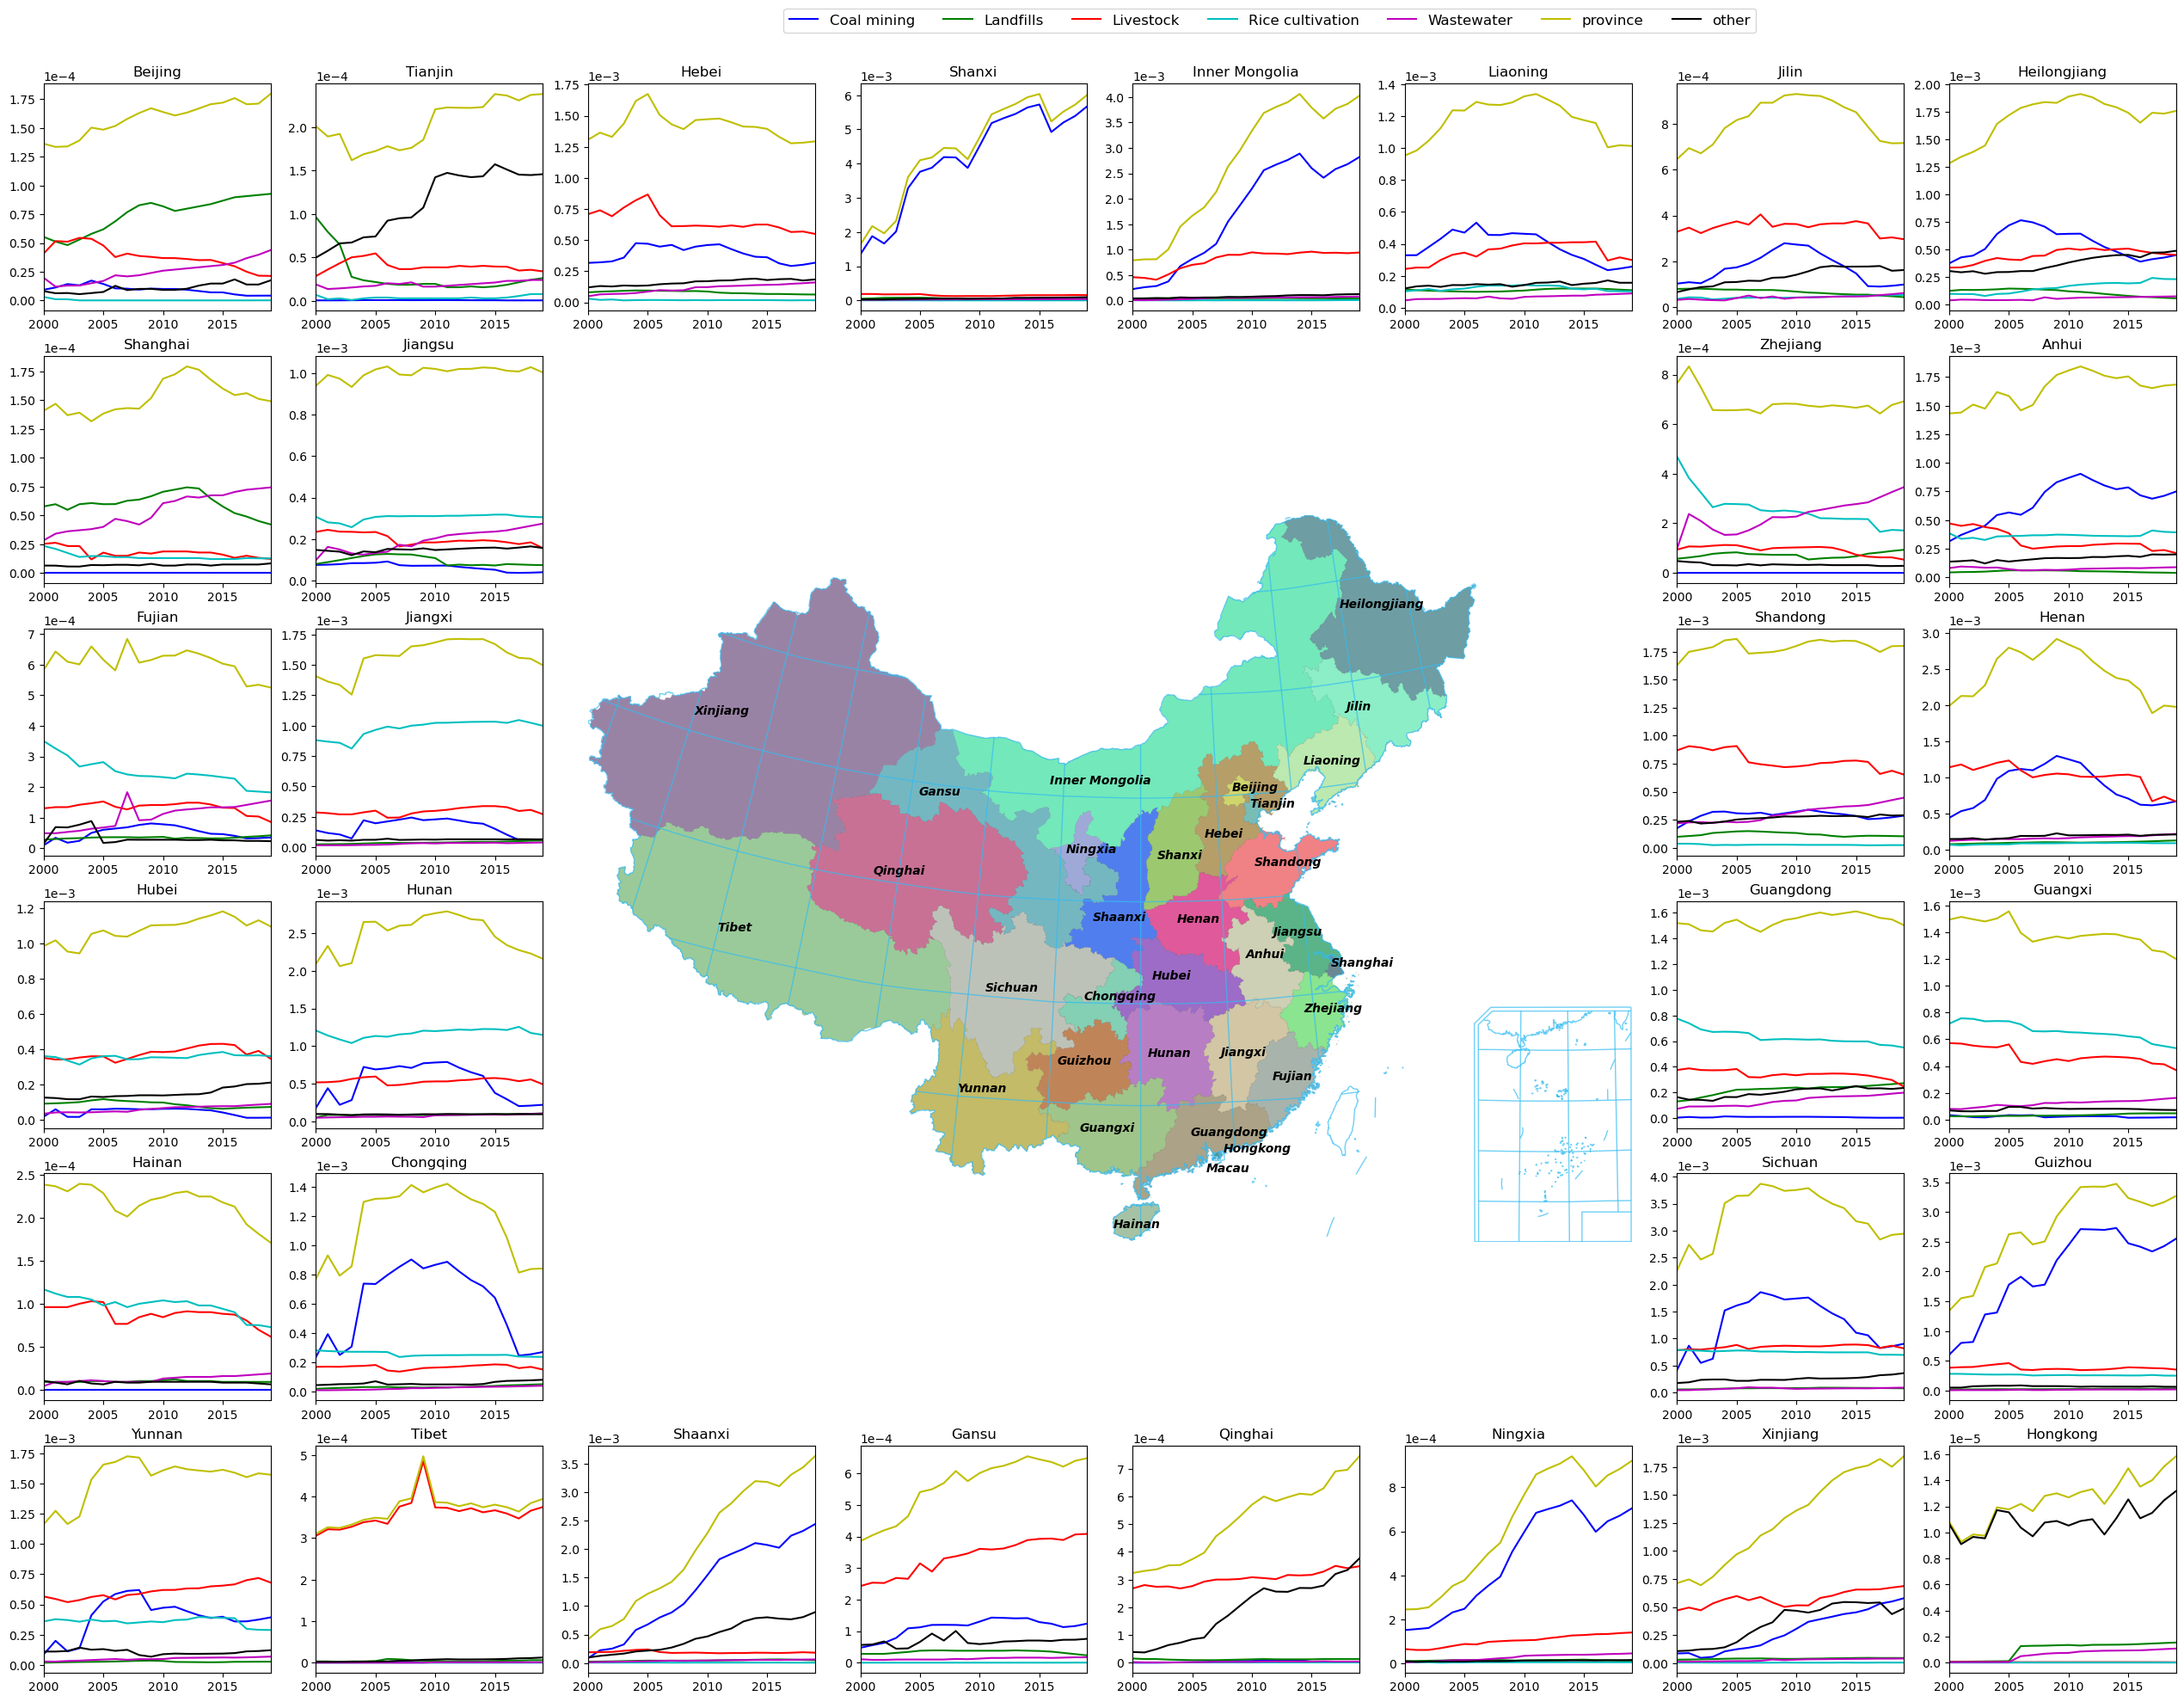

3.808128833770752

In [40]:
star = time.time()
fig = plt.figure(figsize = (32, 24))
grid = GridSpec(6, 8)

lst2 = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
x = np.arange(2000, 2020)

p = 0
for grid_x, i in enumerate(grid_mat):
    for grid_y, j in enumerate(i):
        if j == 0:
            continue
        ax = fig.add_subplot(grid[grid_x, grid_y])
        for t in range(7):
            y = lst[p].iloc[t, :]
            ax.plot(x, y, color=lst2[t], label=key0[t])
        ax.set_title(names[p])
        ax.set(xlim=(2000, 2019), xticks=np.arange(2000, 2019, 5))
        ax.ticklabel_format(style='sci', scilimits=(-1, 2), axis='y')
        p += 1


dic = {'Guangdong':(0.4,0.6),'Hainan':(0,0.9),'Macau':(0,-5),'Hongkong':(1,1), 'Hebei':(0.1,0.3),
       'Shanxi':(0.2,0.4), 'Jiangxi': (0.2,0.5), 'Inner Mongolia':(0.2,0.2), 'Gansu':(0.2,0.7),
       'Shaanxi':(0.3,0.3)}

gdf_pl = gpd.read_file(path_line)
gdf_py = gpd.read_file(path_polygon).to_crs(gdf_pl.crs)

crs =  get_crs(gdf_pl)
ax = fig.add_subplot(grid[1:5, 2:6], projection=crs)

newcmp = LinearSegmentedColormap.from_list('chaos',colors)
gpd.plotting.plot_dataframe(gdf_py, ax=ax, edgecolor='black', linewidth=0.05, cmap=newcmp, alpha=0.7)

for i, record in gdf_py.iterrows():
    name = record['NAME']
    bound = record.geometry.bounds
    
    x_l = bound[2]-bound[0]
    y_l = bound[3]-bound[1]
    
    if name in dic:
        x = bound[0]+dic[name][0]*x_l
        y = bound[1]+dic[name][1]*y_l
    
    else:
        x = bound[0]+x_l*0.3
        y = bound[1]+y_l*0.5
    
    ax.text(x, y, name, fontsize=10,fontstyle='oblique',fontweight= 'bold', transform=crs)

gpd.plotting.plot_dataframe(gdf_pl, linewidth=1, color='#33bcf2', ax=ax, alpha=0.7)
bounds = gdf_pl.bounds
geo_bound = [bounds['minx'].min(), bounds['maxx'].max(), bounds['miny'].min(), bounds['maxy'].max()]
ax.set_extent(geo_bound, crs=crs)

ax.axis('off')
labels = lst[1].index
fig.legend(labels, bbox_to_anchor=(0.75, 0.92), ncol=7, fontsize='large', title_fontsize="10")
plt.show()
time.time() - star

In [ ]:
fig = plt.figure()

In [5]:
from cartopy.crs import Projection

In [6]:
gdf_pl = gpd.read_file(path_line)
gdf_py = gpd.read_file(path_polygon).to_crs(gdf_pl.crs)

In [8]:
class AlbersEqualArea1(Projection):
    
    def __init__(self, crs):
        import warnings
        warnings.filterwarnings('ignore')

        crs_dict = crs.to_dict()
        proj4_params = [(key, value) for key, value in crs_dict.items()]
        super().__init__(proj4_params)
        
    @property
    def boundary(self):
        return self._boundary

    @property
    def x_limits(self):
        return self._x_limits

    @property
    def y_limits(self):
        return self._y_limits

AttributeError: 'AxesSubplot' object has no attribute 'add_geometries'

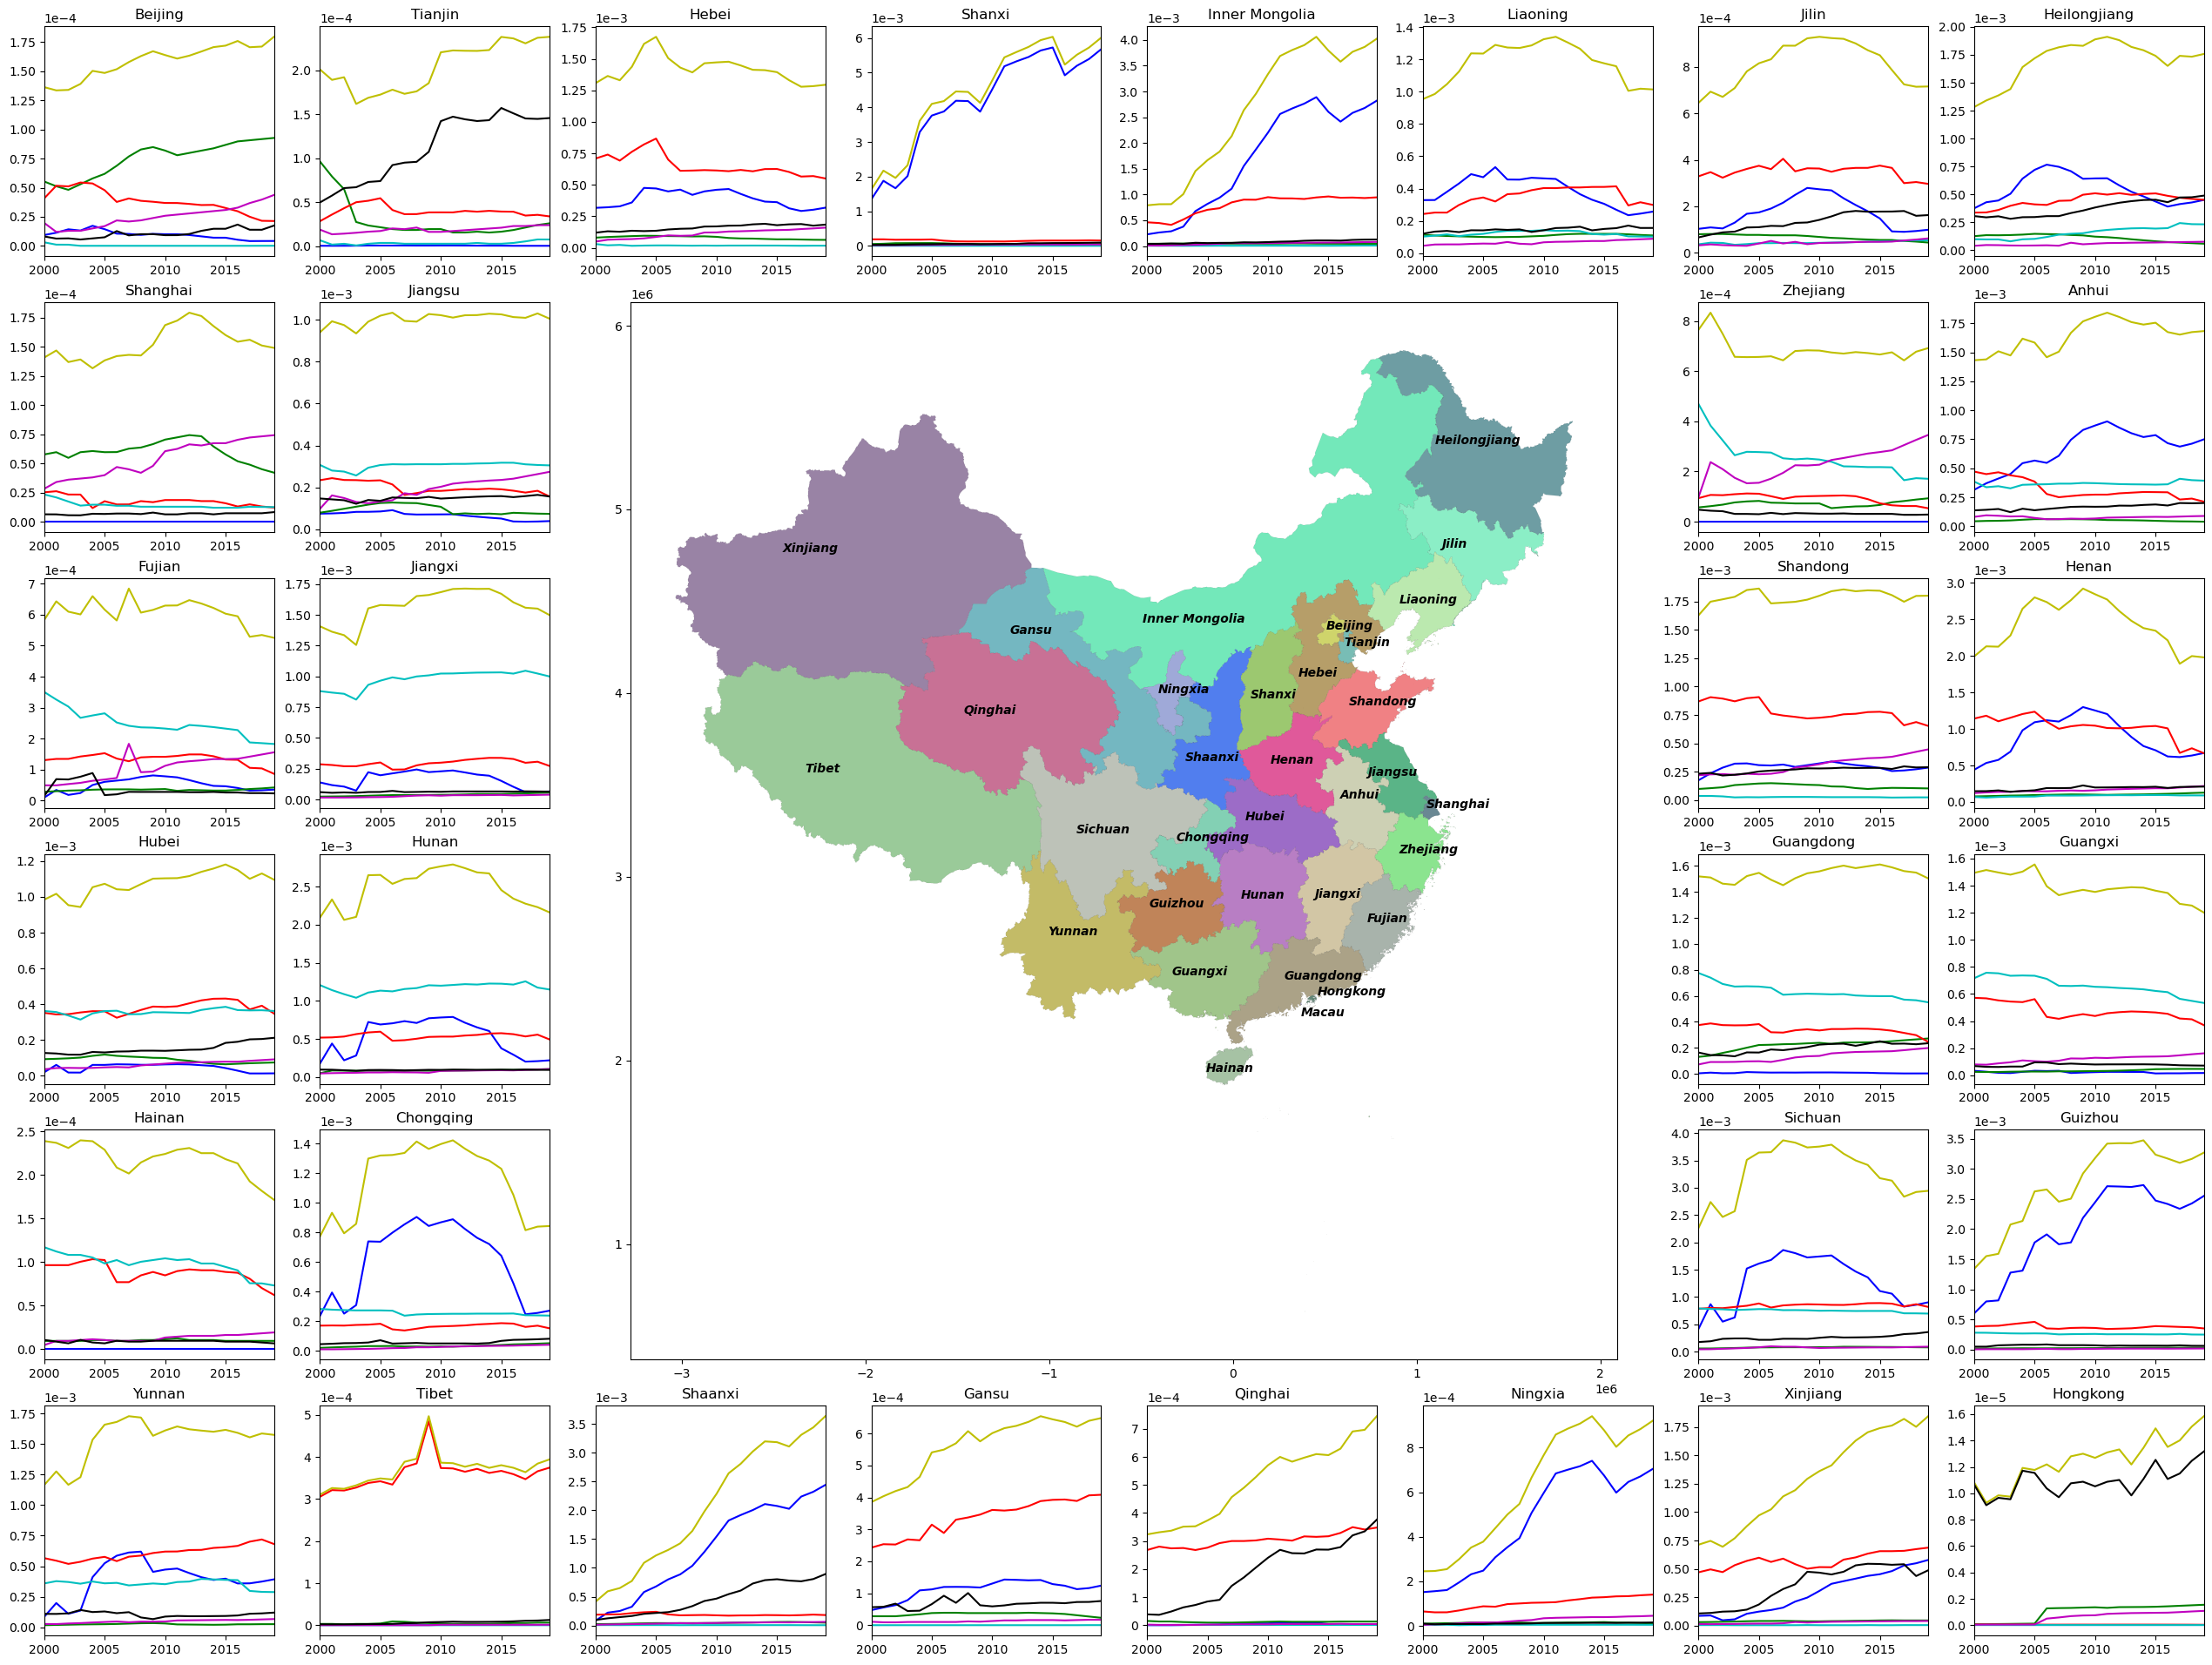

In [38]:
star = time.time()
fig = plt.figure(figsize = (32, 24))
grid = GridSpec(6, 8)

lst2 = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
x = np.arange(2000, 2020)

p = 0
for grid_x, i in enumerate(grid_mat):
    for grid_y, j in enumerate(i):
        if j == 0:
            continue
        ax = fig.add_subplot(grid[grid_x, grid_y])
        for t in range(7):
            y = lst[p].iloc[t, :]
            ax.plot(x, y, color=lst2[t], label=key0[t])
        ax.set_title(names[p])
        ax.set(xlim=(2000, 2019), xticks=np.arange(2000, 2019, 5))
        ax.ticklabel_format(style='sci', scilimits=(-1, 2), axis='y')
        p += 1


dic = {'Guangdong':(0.4,0.6),'Hainan':(0,0.9),'Macau':(0,-5),'Hongkong':(1,1), 'Hebei':(0.1,0.3),
       'Shanxi':(0.2,0.4), 'Jiangxi': (0.2,0.5), 'Inner Mongolia':(0.2,0.2), 'Gansu':(0.2,0.7),
       'Shaanxi':(0.3,0.3)}

gdf_pl = gpd.read_file(path_line)
gdf_py = gpd.read_file(path_polygon).to_crs(gdf_pl.crs)

ax = fig.add_subplot(grid[1:5, 2:6])

newcmp = LinearSegmentedColormap.from_list('chaos',colors)
gpd.plotting.plot_dataframe(gdf_py, ax=ax, edgecolor='black', linewidth=0.05, cmap=newcmp, alpha=0.7)

for i, record in gdf_py.iterrows():
    name = record['NAME']
    bound = record.geometry.bounds
    
    x_l = bound[2]-bound[0]
    y_l = bound[3]-bound[1]
    
    if name in dic:
        x = bound[0]+dic[name][0]*x_l
        y = bound[1]+dic[name][1]*y_l
    
    else:
        x = bound[0]+x_l*0.3
        y = bound[1]+y_l*0.5
    
    ax.text(x, y, name, fontsize=10,fontstyle='oblique',fontweight= 'bold')

# gpd.plotting.plot_dataframe(gdf_pl, linewidth=1, color='#33bcf2', ax=ax, alpha=0.7)
ax.add_geometries(gdf_pl.geometry, linewidth=1, color='#33bcf2', ax=ax, alpha=0.7)
bounds = gdf_pl.bounds
ax.set_xlim((bounds['minx'].min(), bounds['maxx'].max()))
ax.set_ylim((bounds['miny'].min(), bounds['maxy'].max()))

ax.axis('off')
labels = lst[1].index
fig.legend(labels, bbox_to_anchor=(0.75, 0.92), ncol=7, fontsize='large', title_fontsize="10")
plt.show()
time.time() - star

In [ ]:
a.items

In [12]:
gdf_pl.crs

False

In [15]:
central_longitude = 110
epsilon = 1e-10
minlon = -180 + central_longitude
maxlon = 180 + central_longitude
if central_longitude > 0:
    maxlon -= epsilon
elif central_longitude < 0:
    minlon += epsilon
minlon, maxlon

(-70, 289.9999999999)

In [16]:
n = 103
lons = np.empty(2 * n + 1)
lats = np.empty(2 * n + 1)
tmp = np.linspace(minlon, maxlon, n)
lons[:n] = tmp
lats[:n] = 90
lons[n:-1] = tmp[::-1]
lats[n:-1] = -90
lons[-1] = lons[0]
lats[-1] = lats[0]

In [ ]:
points = 

In [14]:
gdf_pl.crs.to_dict()

{'proj': 'aea',
 'lat_0': 0,
 'lon_0': 110,
 'lat_1': 25,
 'lat_2': 47,
 'x_0': 0,
 'y_0': 0,
 'ellps': 'clrk66',
 'units': 'm',
 'no_defs': None,
 'type': 'crs'}

In [17]:
crs1 =  get_crs(gdf_pl)

<AxesSubplot:>

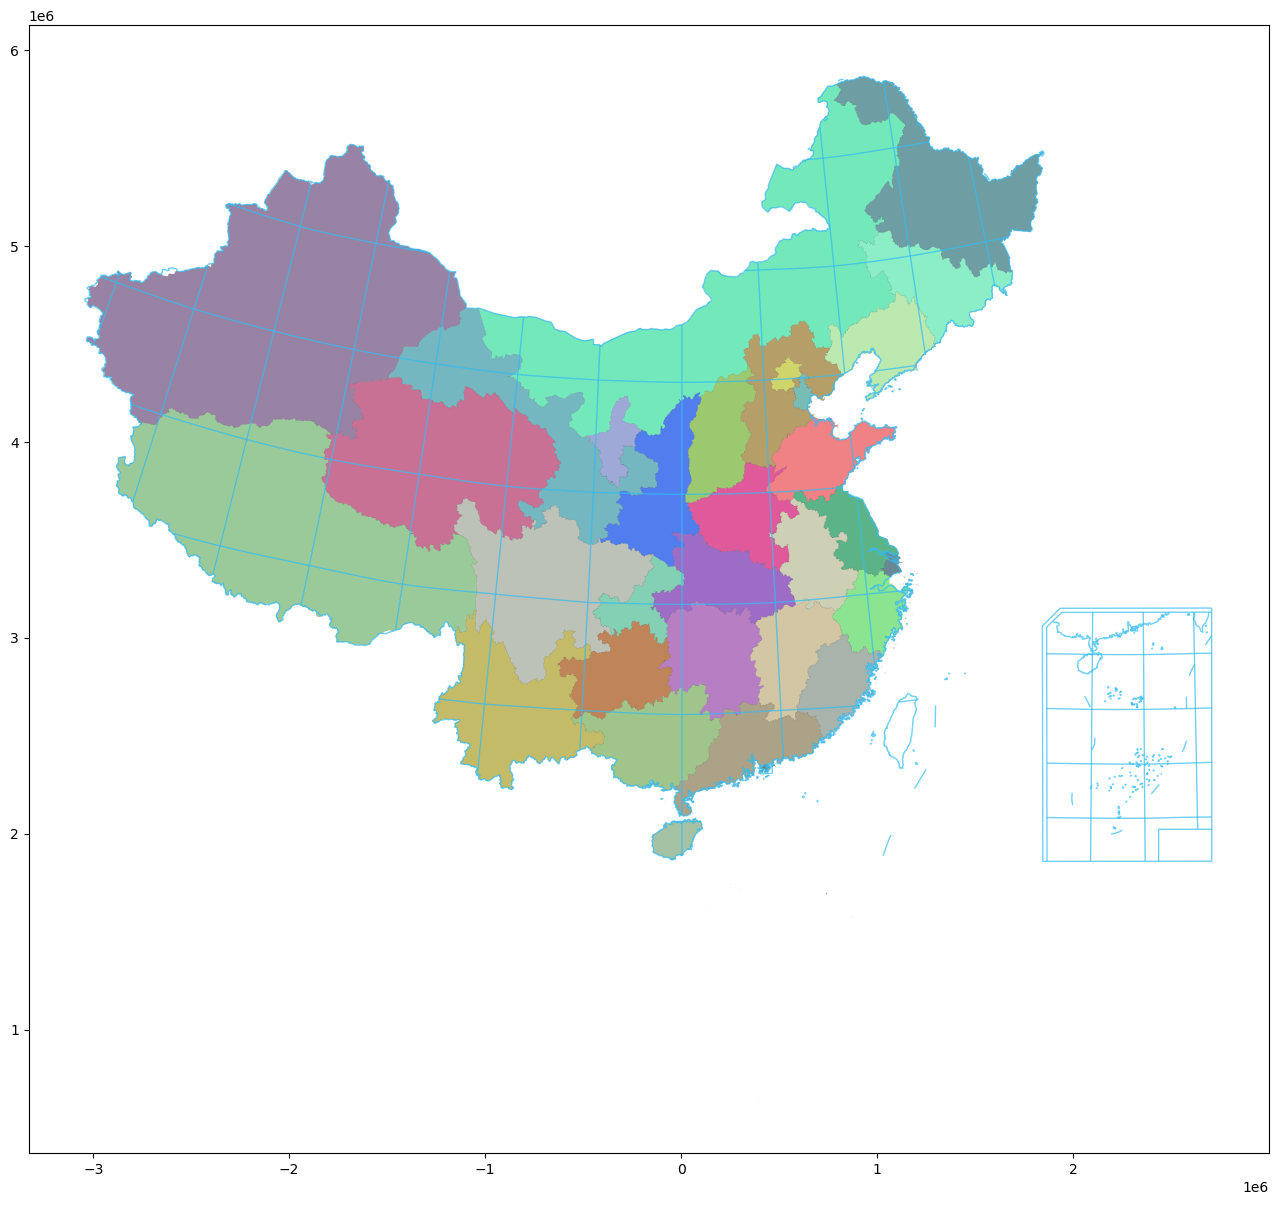

In [27]:
fig, ax = plt.subplots(figsize=(16, 16))
gpd.plotting.plot_dataframe(gdf_py, ax=ax, edgecolor='black', linewidth=0.05, cmap=newcmp, alpha=0.7)
gpd.plotting.plot_dataframe(gdf_pl, linewidth=1, color='#33bcf2', ax=ax, alpha=0.7)